In [1]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2024-10-24 07:48:50.232679: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 07:48:50.264937: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 07:48:50.401595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 07:48:50.401643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 07:48:50.430644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


In [2]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Datasets/dataset_reduced_paper.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (602649, 17)


,turbine,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,R80736,944.234446,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,1.801180,29.480000,222.05,222.05,10823.5,2043069.9
602645,R80736,959.131349,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,1.798038,29.379999,221.98,221.98,10843.5,2043060.1
602646,R80736,995.227747,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,1.801180,32.730000,203.55,203.55,10853.3,2048070.1
602647,R80711,963.715011,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,1.801180,26.010000,237.59,237.59,10817.3,2041980.0
602648,R80736,1008.978735,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,1.799085,27.200001,219.62,219.62,10837.3,2043120.0


In [3]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine                0
theta                  0
hub_temperature        0
nacelle_angle          0
nacelle_temperature    0
V1                     0
V2                     0
V                      0
Wind_angle             0
Vane_angle             0
Out_temperature        0
W                      0
Rotor_temperature      0
Wind_angle_c           0
nacelle_angle_c        0
T                      0
P                      0
dtype: int64


In [4]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,944.234446,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,1.801180,29.480000,222.05,222.05,10823.5,2043069.9
602645,959.131349,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,1.798038,29.379999,221.98,221.98,10843.5,2043060.1
602646,995.227747,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,1.801180,32.730000,203.55,203.55,10853.3,2048070.1
602647,963.715011,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,1.801180,26.010000,237.59,237.59,10817.3,2041980.0
602648,1008.978735,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,1.799085,27.200001,219.62,219.62,10837.3,2043120.0


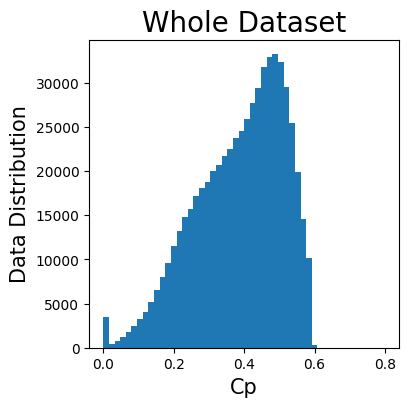

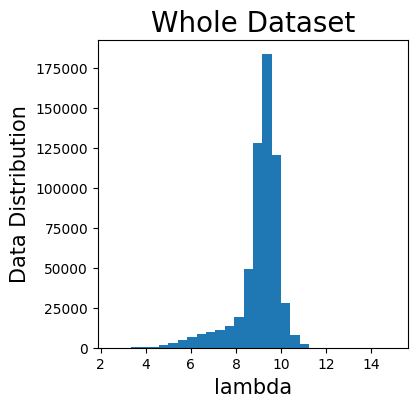

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P,Cp,lambda
602644,944.234446,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,1.801180,29.480000,222.05,222.05,10823.5,2043069.9,0.079908,3.707248
602645,959.131349,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,1.798038,29.379999,221.98,221.98,10843.5,2043060.1,0.078364,3.676787
602646,995.227747,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,1.801180,32.730000,203.55,203.55,10853.3,2048070.1,0.073819,3.607639
602647,963.715011,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,1.801180,26.010000,237.59,237.59,10817.3,2041980.0,0.073492,3.605878
602648,1008.978735,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,1.799085,27.200001,219.62,219.62,10837.3,2043120.0,0.073318,3.598171


In [5]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [6]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-4.643517,342.545648,-61.879442,-57.295780,-56.722822,-51.566200,5.314757e+03
hub_temperature,602649.0,19.060174,5.838598,4.050000,14.170000,18.719999,23.000000,3.900000e+01
nacelle_angle,602649.0,180.414785,92.988829,0.000000,102.290000,200.679990,246.100010,3.600000e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.490000,20.639999,25.110001,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.000000,4.950000,5.870000,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.000000,4.990000,5.900000,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,0.230000,4.970000,5.890000,7.130000,2.050000e+01
Wind_angle,602649.0,180.053769,92.830444,0.000000,102.270000,199.610000,245.160000,3.600000e+02
Vane_angle,602649.0,-0.184985,9.427393,-179.340000,-5.310000,-0.460000,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.950000,5.960000,10.910000,16.330000,3.828000e+01


In [7]:
# Normalization 
# Cp in the range [0,1]. Originally, it was in [0,Cp_max]
# Rest of the variables with mean 0 and std 1

print(dataset.describe().transpose()[['mean', 'std']])

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )

column_name = dataset.columns.values
Cp_column = column_name[5]
#print(Cp_column)

Cp_max = 0.5926
dataset_norm = dataset.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        dataset_norm[col]=(dataset[col]-x_mean[icol])/x_std[icol]        
    else: # Cp in [0,1]
        dataset_norm[col]=dataset[col]/Cp_max
    icol = icol+1

print()
print("Normalized dataset")
print(dataset_norm.describe().transpose()[['mean', 'std']])

                              mean            std
theta                    -4.643517     342.545648
hub_temperature          19.060174       5.838598
nacelle_angle           180.414785      92.988829
nacelle_temperature      24.595032       6.192875
V1                        6.306669       2.018830
V2                        6.321526       1.956744
V                         6.314169       1.982688
Wind_angle              180.053769      92.830444
Vane_angle               -0.184985       9.427393
Out_temperature          11.473260       7.091906
W                         1.362470       0.318853
Rotor_temperature        28.486577       4.714501
Wind_angle_c            179.627065      92.421807
nacelle_angle_c         179.767785      92.504951
T                      2646.532389    2258.267705
P                    444860.879260  446349.165241
Cp                        0.386876       0.124435
lambda                    9.004813       1.167138

Normalized dataset
                             m

In [8]:
# load existing Cp model
Cp_model = tf.keras.models.load_model('../Models/Cp3D_sigmoid_model.h5')
Cp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               512       
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17153 (67.00 KB)
Trainable params: 17153 (67.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-10-24 07:49:03.770647: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
# load existing Pphys model
from keras import backend as K
from keras.layers import Input, Lambda
from keras.layers import Concatenate
V_mean = 6.314169410268349
V_std = 1.9826865496833004

Pphys_model = tf.keras.models.load_model('../Models/Pphys.h5')
Pphys_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xphys (InputLayer)          [(None, 3)]                  0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['xphys[0][0]']               
                                                                                                  
 sequential_1 (Sequential)   (None, 1)                    17153     ['xphys[0][0]']               
                                                                                                  
 lambda_3 (Lambda)           (None, 1)                    0         ['lambda[0][0]',              
                                                                     'sequential_1[0][0]']    

In [10]:
# Define input features of P_phys model
dataset_copy = dataset_norm.copy()
xphys = dataset_copy[['V','theta','W']]

# Evaluate power in normalized units
P_phys = Pphys_model.predict(xphys).flatten()

18833/18833 [==============================] - 8s 432us/step


In [11]:
# Add physical and residual power to the dataset
dataset['P_phys'] = P_phys
dataset.describe().transpose()
#dataset['P_res'] = dataset['P_phys'] - dataset['P']
dataset['P_res'] = dataset['P'] - dataset['P_phys']
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-4.643517,342.545648,-6.187944e+01,-57.295780,-5.672282e+01,-51.566200,5.314757e+03
hub_temperature,602649.0,19.060174,5.838598,4.050000e+00,14.170000,1.872000e+01,23.000000,3.900000e+01
nacelle_angle,602649.0,180.414785,92.988829,0.000000e+00,102.290000,2.006800e+02,246.100010,3.600000e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.490000e+00,20.639999,2.511000e+01,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.000000e+00,4.950000,5.870000e+00,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.000000e+00,4.990000,5.900000e+00,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,2.300000e-01,4.970000,5.890000e+00,7.130000,2.050000e+01
Wind_angle,602649.0,180.053769,92.830444,0.000000e+00,102.270000,1.996100e+02,245.160000,3.600000e+02
Vane_angle,602649.0,-0.184985,9.427393,-1.793400e+02,-5.310000,-4.600000e-01,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.950000e+00,5.960000,1.091000e+01,16.330000,3.828000e+01


In [12]:
Pphys_mean = P_phys.mean()
Pphys_std = P_phys.std()
Pres_mean = dataset['P_res'].mean()
Pres_std = dataset['P_res'].std()

In [13]:
# Normalize dataset
#P_phys_norm = (P_phys - dataset['P_phys'].mean())/dataset['P_phys'].std() # Normalize Power  
P_phys_norm = (P_phys - P_phys.mean())/P_phys.std() # Normalize Power  
dataset_norm['P_phys'] = P_phys_norm
dataset_norm['P_res'] = ( dataset['P_res'] - dataset['P_res'].mean() )/dataset['P_res'].std()
dataset_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,2.263742e-17,1.000001,-0.167090,-0.153709,-0.152036,-0.136982,15.529038
hub_temperature,602649.0,7.081741e-16,1.000001,-2.570855,-0.837560,-0.058263,0.674790,3.415176
nacelle_angle,602649.0,-1.786470e-16,1.000001,-1.940179,-0.840153,0.217932,0.706378,1.931257
nacelle_temperature,602649.0,-3.561621e-16,1.000001,-3.730909,-0.638643,0.083155,0.706452,2.957428
V1,602649.0,5.070783e-16,1.000001,-3.123925,-0.672008,-0.216298,0.407826,7.416842
V2,602649.0,1.992093e-16,1.000001,-3.230637,-0.680481,-0.215422,0.418284,7.067088
V,602649.0,4.829317e-17,1.000001,-3.068649,-0.677954,-0.213937,0.411477,7.154853
Wind_angle,602649.0,4.199242e-16,1.000001,-1.939600,-0.837913,0.210666,0.701346,1.938441
Vane_angle,602649.0,-3.372033e-18,1.000001,-19.003680,-0.543631,-0.029172,0.528777,19.086414
Out_temperature,602649.0,7.949508e-16,1.000001,-2.597789,-0.777402,-0.079423,0.684829,3.779909


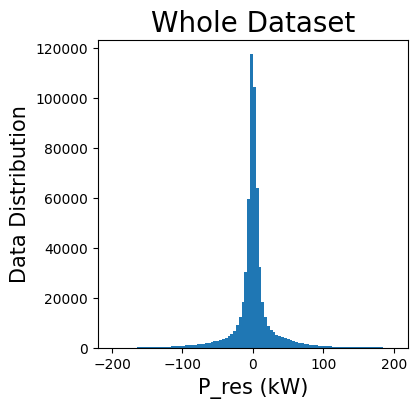

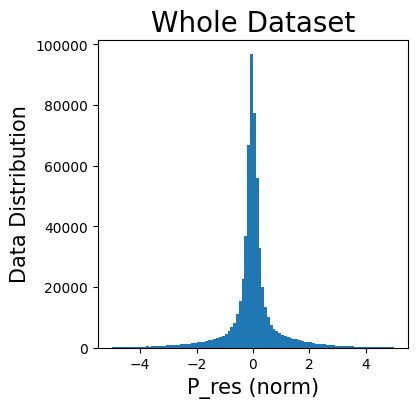

In [14]:
# Plot distribution of P_res in kW
Pres_data = dataset['P_res']
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_data/1000, range=[-200, 200], bins=100)
plt.xlabel('P_res (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Normalized Pres
Pres_norm = dataset_norm['P_res']
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_norm, range=[-5, 5], bins=100)
plt.xlabel('P_res (norm)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

In [15]:
# Split the data into training and test sets
train_dataset = dataset_norm.sample(frac=0.8, random_state=10)
test_dataset = dataset_norm.drop(train_dataset.index)

# Data to fit
#x_train = train_dataset[['V','theta','W','Out_temperature']]
x_train = train_dataset['Out_temperature']
y_train = train_dataset['P_res']

# Test data
#x_test = test_dataset[['V','theta','W','Out_temperature']]
x_test = test_dataset['Out_temperature']
y_test = test_dataset['P_res']

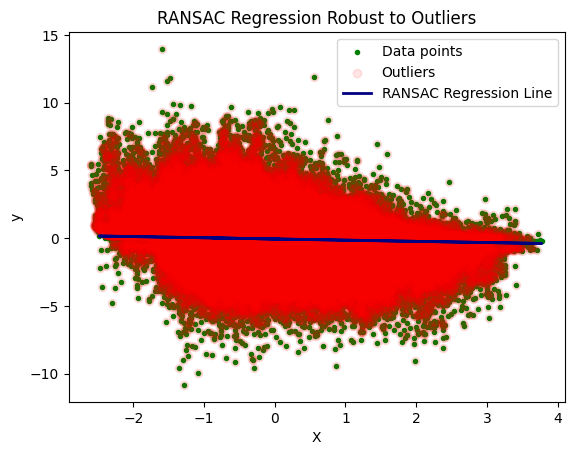

Slope: -0.08784127944303786
Intercept (Origin ordinate): -0.06647750568632829


In [16]:
# Fit residual power with interpretable terms

from sklearn.linear_model import RANSACRegressor, LinearRegression

X = x_train.to_numpy()
Y = y_train.to_numpy()
# Reshape X to be a 2D array
X = X.reshape(-1, 1)  # Reshape to 2D

# Fit the RANSAC regressor
#model = LinearRegression()
#ransac = RANSACRegressor(base_estimator=model, random_state=0)
ransac = RANSACRegressor(random_state=0)
ransac.fit(X, Y)

# Predict using the inlier model
inlier_mask = ransac.inlier_mask_
X_inliers = X[inlier_mask]
y_inliers = Y[inlier_mask]

# Plotting the results
plt.scatter(X, Y, color='green', marker='.', label='Data points')
plt.scatter(X[~inlier_mask], Y[~inlier_mask], color='red', label='Outliers',alpha=0.1)
plt.plot(X_inliers, ransac.predict(X_inliers), color='navy', linewidth=2, label='RANSAC Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('RANSAC Regression Robust to Outliers')
plt.show()

# Get the slope (coefficient) and intercept (origin ordinate)
slope = ransac.estimator_.coef_[0]  # Extract the slope (as it's a 1D array)
intercept = ransac.estimator_.intercept_  # Extract the intercept

print(f"Slope: {slope}")
print(f"Intercept (Origin ordinate): {intercept}")

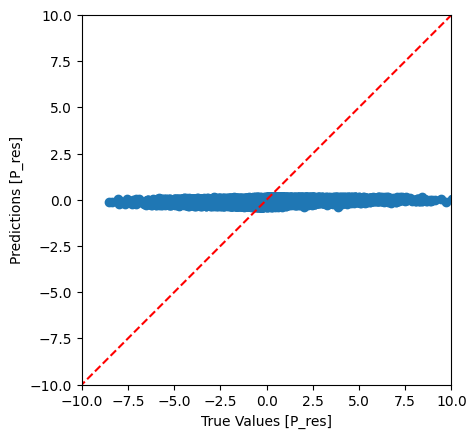


Test MAE: 0.5092254899687614
Test RMSE: 0.9922242455920194
Test MAPE: 356.6775809580001 %
Test R2: 0.03452007218413378


In [17]:
# Evaluate the P_res model on P_res data

# Pred vs True values

#test_pred = model.predict(test_features[['lambda', 'theta']]).flatten()
#test_pred = model.predict(test_features[['V','theta','W']]).flatten()
#test_pred = model.predict(test_features[column_list[:]]).flatten()

# Reshape X to be a 2D array
xx_test = x_test.to_numpy()
xx_test = xx_test.reshape(-1,1) # Reshape to 2D
y_pred = ransac.predict(xx_test)
y_true = y_test.to_numpy()

a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [P_res]')
plt.ylabel('Predictions [P_res]')
lims = [-10, 10]
plt.xlim(lims)
plt.ylim(lims)
#_ = plt.plot(lims, lims)
plt.show()

#test_result = model.evaluate(test_features[['lambda','theta']], test_labels, verbose=0)
#test_result = model.evaluate(test_features[['V','theta','W']], test_labels, verbose=0)
#test_result = model.evaluate(test_features[column_list[:]], test_labels, verbose=0)
#print("Test MAE: "+str(test_result))
test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
#test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

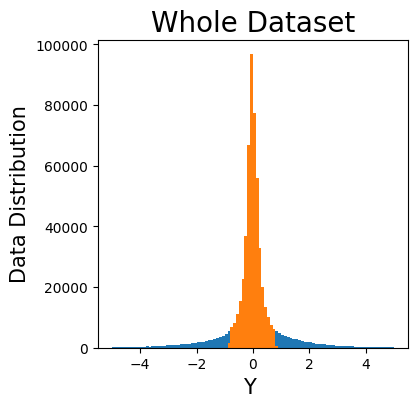

(602649,)
(490272,)
Removed  18.6 % of the data


In [15]:
# Data to fit
X_data = dataset_norm[['V','W','Out_temperature','theta']].to_numpy()
Y_data = dataset_norm['P_res'].to_numpy()

# Remove outliers

# Calculate Q1 (25th percentile) and Q3 (75th percentile) and IQR (interquartile range)
Q1 = np.percentile(Y_data, 25)
Q3 = np.percentile(Y_data, 75)
IQR = Q3 - Q1

# Define outlier thresholds
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Filter data to remove outliers
Y_filtered = Y_data[(Y_data >= lower_bound) & (Y_data <= upper_bound)]
X_filtered = X_data[(Y_data >= lower_bound) & (Y_data <= upper_bound)]

# Y distribution
plt.figure(figsize=(4,4))
plt.hist(Y_data, range=[-5, 5], bins=100)
plt.hist(Y_filtered, range=[-5, 5], bins=100)
plt.xlabel('Y ',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

print(Y_data.shape)
print(Y_filtered.shape)
print('Removed ',round(100-len(Y_filtered)/len(Y_data)*100,1),'% of the data')

    Feature  Coefficient  Abs_Coefficient
2         T    -0.168848         0.168848
6       W T    -0.151794         0.151794
0         W    -0.143251         0.143251
1         V     0.138725         0.138725
9       V T     0.125062         0.125062
5       W V    -0.069659         0.069659
3     theta    -0.044437         0.044437
10  V theta    -0.031699         0.031699
4       W^2     0.030510         0.030510
7   W theta     0.019939         0.019939
12  T theta    -0.019470         0.019470
8       V^2     0.011556         0.011556
11      T^2     0.009072         0.009072
13  theta^2     0.002838         0.002838
Model coefficients: [-0.143  0.139 -0.169 -0.044  0.031 -0.07  -0.152  0.02   0.012  0.125
 -0.032  0.009 -0.019  0.003]
Intercept: -0.014766440933527764
R-squared: 0.30596441071464053


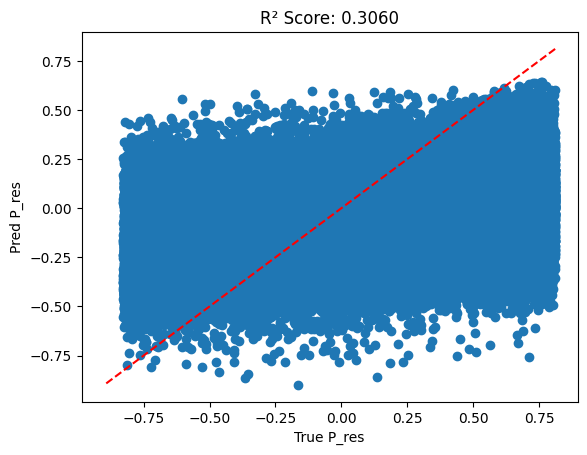

In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

V = X_filtered[:,0]
W = X_filtered[:,1]
T = X_filtered[:,2]
theta = X_filtered[:,3]
Y = Y_filtered

# Create the feature matrix based on the assumed model: W, V, T
X = np.column_stack((W, V, T,theta))
#X = np.column_stack((W,V,T,W*V,W*T,V*T,W*W,V*V,T*T))
#X = np.column_stack((W,T,W*T))
#X = np.column_stack((T,W*T,V**3))

# Generate all polynomial features up to second order (including interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Fit a linear regression model
model = LinearRegression()
#model.fit(X, Y)
model.fit(X_poly, Y)

# Get the predicted values
#Y_pred = model.predict(X)
Y_pred = model.predict(X_poly)

# Calculate R-squared score
r2 = r2_score(Y, Y_pred)

# Get model coefficients
coefficients = model.coef_
# Get feature names for each term
feature_names = poly.get_feature_names_out(['W', 'V', 'T','theta'])
# Create a dataframe for feature names and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# Sort by the absolute value of the coefficients to find the most important terms
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
# Print the sorted coefficients
print(coef_df)


# Print model coefficients and R-squared score
print("Model coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R-squared:", r2)

# Optional: Plot the predictions vs actual
p1 = max(max(Y_pred), max(Y))
p2 = min(min(Y_pred), min(Y))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(Y, Y_pred)
plt.xlabel('True P_res')
plt.ylabel('Pred P_res')
plt.title(f'R² Score: {r2:.4f}')
plt.show()

/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.769214818275941, tolerance: 2.0703820736412943
  model = cd_fast.enet_coordinate_descent_gram(
/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.47903401253643, tolerance: 2.0703820736412943
  model = cd_fast.enet_coordinate_descent_gram(
/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.38333377533126

Selected features after Lasso regularization:
    Feature  Coefficient  Abs_Coefficient
2         T    -0.153456         0.153456
6       W T    -0.033448         0.033448
0         W    -0.015943         0.015943
11      T^2     0.010135         0.010135
13  theta^2    -0.000331         0.000331


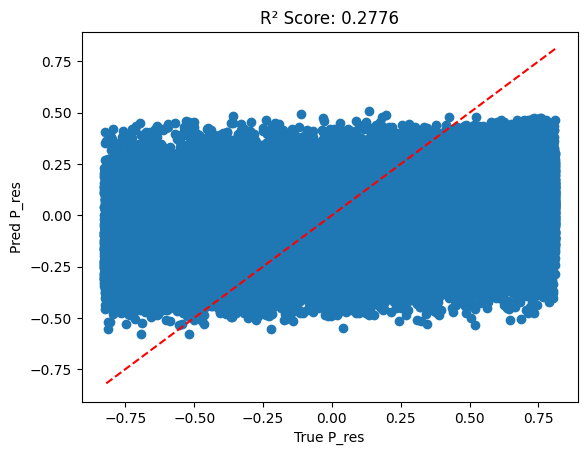

In [127]:
from sklearn.linear_model import LassoCV

V = X_filtered[:,0]
W = X_filtered[:,1]
T = X_filtered[:,2]
theta = X_filtered[:,3]
Y = Y_filtered

# Create the feature matrix based on the assumed model: W, V, T
X = np.column_stack((W, V, T,theta))
#X = np.column_stack((W,V,T,W*V,W*T,V*T,W*W,V*V,T*T))
#X = np.column_stack((W,T,W*T))
#X = np.column_stack((T,W*T,V**3))

# Generate all polynomial features up to second order (including interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Perform Lasso regression with cross-validation to automatically find the best alpha
lasso = LassoCV(cv=5, random_state=0)  # cv=5 for 5-fold cross-validation
lasso.fit(X_poly, Y)

# Get the predicted values
Y_pred = lasso.predict(X_poly)

# Calculate R-squared score
r2 = r2_score(Y, Y_pred)


# Get feature names for each term
feature_names = poly.get_feature_names_out(['W', 'V', 'T','theta'])
# Create a dataframe for feature names and their corresponding coefficients
lasso_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso.coef_})
# Sort by the absolute value of the coefficients to find the most important terms
lasso_coef_df['Abs_Coefficient'] = np.abs(lasso_coef_df['Coefficient'])
lasso_coef_df = lasso_coef_df.sort_values(by='Abs_Coefficient', ascending=False)
# Print the sorted coefficients
print("Selected features after Lasso regularization:")
print(lasso_coef_df[lasso_coef_df['Coefficient'] != 0])

# Optional: Plot the predictions vs actual
p1 = max(max(Y_pred), max(Y))
p2 = min(min(Y_pred), min(Y))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(Y, Y_pred)
plt.xlabel('True P_res')
plt.ylabel('Pred P_res')
plt.title(f'R² Score: {r2:.4f}')
plt.show()

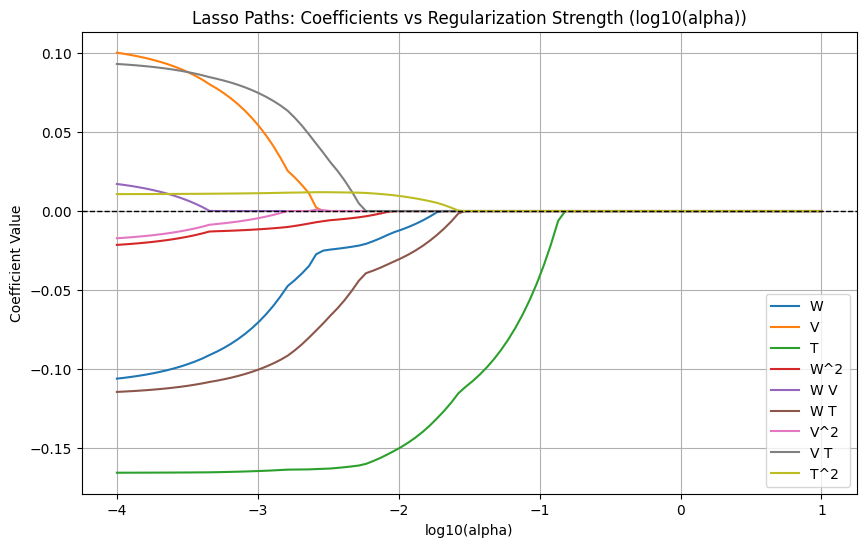

In [125]:
from sklearn.linear_model import Lasso

# Plot of Lasso paths

V = X_filtered[:,0]
W = X_filtered[:,1]
T = X_filtered[:,2]
Y = Y_filtered

# Create a feature matrix from W, V, and T
X = np.column_stack((W, V, T))

# Generate all polynomial features up to second order (including interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Define a range of alpha values (regularization strength)
alphas = np.logspace(-4, 1, 100)  # From 0.0001 to 10 (logarithmic scale)

# Track the coefficients for each feature
coefs = []

# Loop through each alpha and fit a Lasso model
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_poly, Y)
    coefs.append(lasso.coef_)

# Convert the list of coefficients to a numpy array for easy plotting
coefs = np.array(coefs)

# Get the feature names from the PolynomialFeatures object
feature_names = poly.get_feature_names_out(['W', 'V', 'T'])

# Plot the Lasso paths (coefficients vs. log(alpha))
plt.figure(figsize=(10, 6))

for i in range(coefs.shape[1]):
    plt.plot(np.log10(alphas), coefs[:, i], label=feature_names[i])

plt.xlabel('log10(alpha)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Paths: Coefficients vs Regularization Strength (log10(alpha))')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(loc='best')
plt.grid(True)
plt.show()

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/tmp/ipykernel_14761/1178679754.py:18: RuntimeWarning: overflow encountered in exp
  return np.where(x < 100, np.exp(x), 0)  # Prevent overflow
/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/gplearn/functions.py:127: RuntimeWarning: overflow encountered in divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    11.32      3.34123e+42        4         0.180766         0.177432     56.47s
   1     6.49      1.33252e+36        4         0.179939         0.184875     41.00s
   2     3.83          12.7891        5          0.17803         0.181973     27.72s
   3     3.73          12.4018        6         0.176554          0.18185     27.17s
   4     3.82      1.25762e+12        5         0.177545         0.186337     25.67s
   5     4.01       1.2926e+36        5         0.169568         0.171342     24.70s
   6     4.07      8.63955e+34        5         0.169224         0.174437     23.48s
   7     4.19      1.24368e+12        4         0.169204         0.175186     24.71s
   8     4.44      1.15796e+26        4         0.169124         0.175909     21.86s
   9     3.98      1.53065e+36        4         0.168948         0.177495     16.11s
  10     3.48      1.24977e+36        4         0.168971          0.17728     12.27s
  11     3.24      4.78672e+35        3         0.168851         

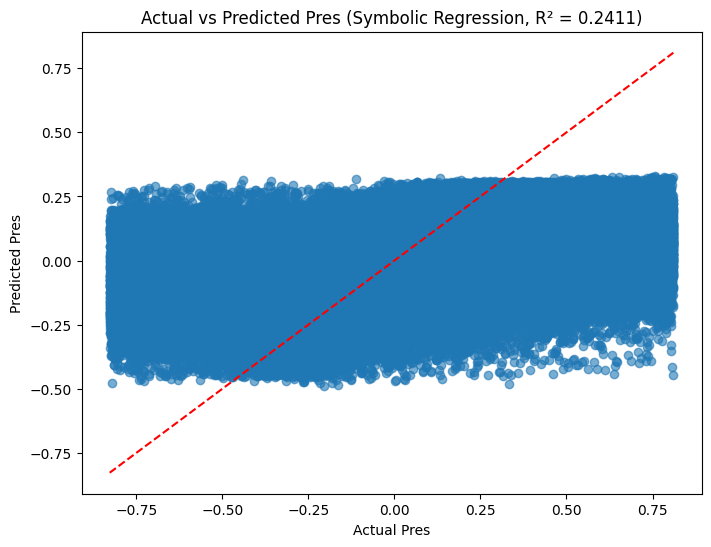

In [130]:
from sklearn.model_selection import train_test_split
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function

V = X_filtered[:,0]
W = X_filtered[:,1]
T = X_filtered[:,2]
theta = X_filtered[:,3]
X_fit = np.column_stack((V,theta,W,T))
Y_fit = Y_filtered

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X_fit, Y_fit, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_fit, Y_fit, test_size=0.9, random_state=42)

# Define the exp function
def _exp(x):
    return np.where(x < 100, np.exp(x), 0)  # Prevent overflow
exp = make_function(function=_exp, name='exp', arity=1)  # arity=1 means it takes 1 argument

def _safe_log(x):
    return np.where(x > 0, np.log(x), 0)  # Only take log of positive values
def _safe_sqrt(x):
    return np.where(x >= 0, np.sqrt(x), 0)  # Only take sqrt of non-negative values

log = make_function(function=_safe_log, name='log', arity=1)
sqrt = make_function(function=_safe_sqrt, name='sqrt', arity=1)

# Define the symbolic regressor
est_gp = SymbolicRegressor(population_size=1000,
                           generations=20,
                           stopping_criteria=0.01,
                           function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', exp, log, sqrt),
                           p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1, parsimony_coefficient=0.01, random_state=0)

# You may want to track the complexity of the resulting symbolic expressions. 
# gplearn has a built-in method to limit the maximum complexity of the 
# expressions using the parsimony_coefficient. 
# If the resulting expressions are too complex, increasing this coefficient 
# can penalize longer, more complex models.

# Fit the symbolic regressor to the training data
est_gp.fit(X_train, y_train)

# Predict on the test data
y_pred_symbolic = est_gp.predict(X_test)

# Calculate the R² score for the symbolic regression model
r2_symbolic = r2_score(y_test, y_pred_symbolic)
print(f"Symbolic Regression R²: {r2_symbolic:.4f}")

# Output the symbolic function found by the genetic programming
print(f"Best symbolic function: {est_gp._program}")

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_symbolic, alpha=0.6)
plt.xlabel('Actual Pres')
plt.ylabel('Predicted Pres')
plt.title(f'Actual vs Predicted Pres (Symbolic Regression, R² = {r2_symbolic:.4f})')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

Fitted C_T: -1197.5838, Fitted T0: 11.9662
R² score: 0.0785


/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


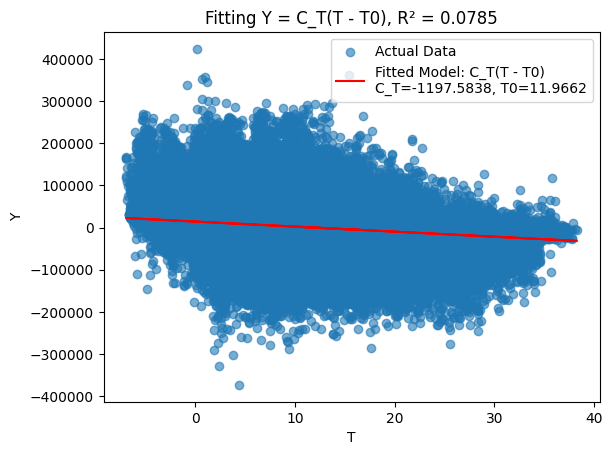

In [35]:
# Fit P_res as C_T*(T-T0) in original units

from scipy.optimize import curve_fit

# Define the regression function: C_T * (T - T0)
def model_func(T, C_T, T0):
    return C_T * (T - T0)


# Assuming T is the feature and Y is the target
T = dataset['Out_temperature'].to_numpy()
Y = dataset['P_res'].to_numpy()

# Fit the model to the data
initial_guess = [-1_000, 15.0]  # Initial guess for C_T and T0
params, covariance = curve_fit(model_func, T, Y, p0=initial_guess)

# Extract fitted parameters
C_T, T0 = params
print(f"Fitted C_T: {C_T:.4f}, Fitted T0: {T0:.4f}")

# Predict Y using the fitted model
Y_pred = model_func(T, C_T, T0)

# Calculate R² score
r2 = 1 - (np.sum((Y - Y_pred)**2) / np.sum((Y - np.mean(Y))**2))
#r2 = r2_score(Y, Y_pred)
print(f"R² score: {r2:.4f}")

# Plot the actual vs predicted values
plt.scatter(T, Y, label='Actual Data', alpha=0.6)
plt.plot(T, Y_pred, color='red', label=f'Fitted Model: C_T(T - T0)\nC_T={C_T:.4f}, T0={T0:.4f}')
plt.xlabel('T')
plt.ylabel('Y')
plt.title(f'Fitting Y = C_T(T - T0), R² = {r2:.4f}')
plt.legend()
plt.show()




-1197.5837661712285 11.966163830576138


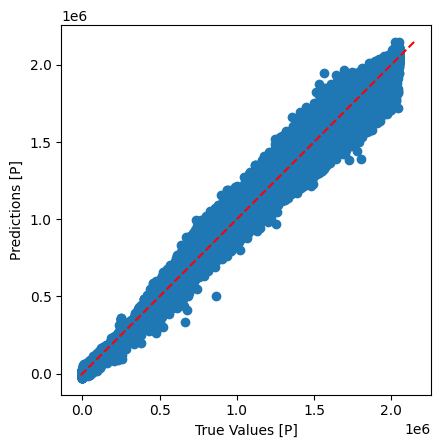


Test MAE: 15572.630787753473
Test RMSE: 29101.108235350526
Test MAPE: 4.5349781781882905 %
Test R2: 0.9957492034124419


In [36]:
# Evaluate new prediction of the power in original units

print(C_T,T0)
T = dataset['Out_temperature'].to_numpy()

y_true = dataset['P'].to_numpy()
y_phys = dataset['P_phys'].to_numpy()
y_pred = y_phys + C_T*(T-T0)

a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
#_ = plt.plot(lims, lims)
plt.show()

P_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>P_cutoff]
y_true_nonzero = y_true[abs(y_true)>P_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

In [ ]:
# Data to fit
X_data = dataset_norm[['V','W','Out_temperature','theta']].to_numpy()
Y_data = dataset_norm['P_res'].to_numpy()

# Remove outliers

# Calculate Q1 (25th percentile) and Q3 (75th percentile) and IQR (interquartile range)
Q1 = np.percentile(Y_data, 25)
Q3 = np.percentile(Y_data, 75)
IQR = Q3 - Q1

# Define outlier thresholds
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Filter data to remove outliers
Y_filtered = Y_data[(Y_data >= lower_bound) & (Y_data <= upper_bound)]
X_filtered = X_data[(Y_data >= lower_bound) & (Y_data <= upper_bound)]

# Y distribution
plt.figure(figsize=(4,4))
plt.hist(Y_data, range=[-5, 5], bins=100)
plt.hist(Y_filtered, range=[-5, 5], bins=100)
plt.xlabel('Y ',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

print(Y_data.shape)
print(Y_filtered.shape)
print('Removed ',round(100-len(Y_filtered)/len(Y_data)*100,1),'% of the data')

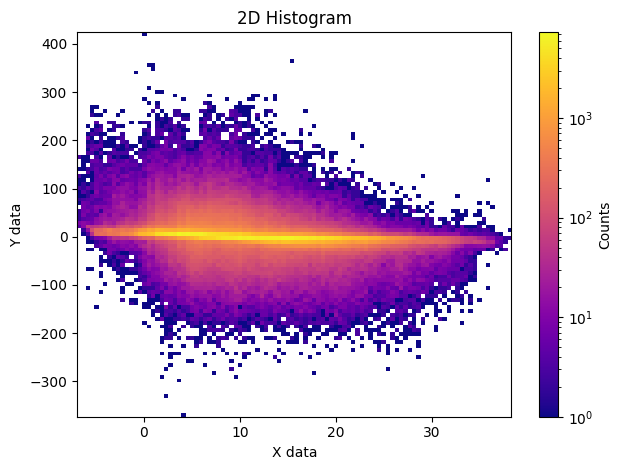

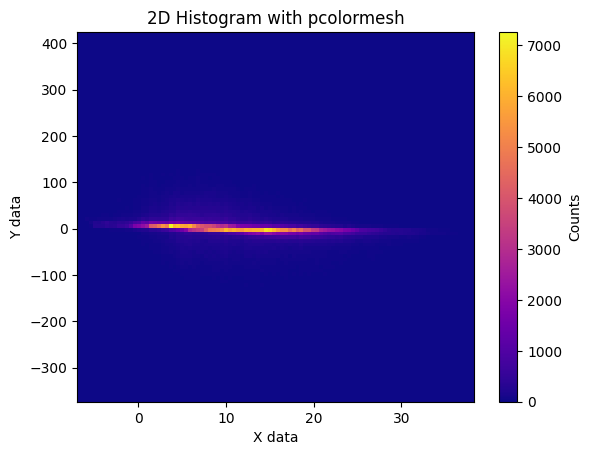

In [51]:
# Exploration of data

from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LogNorm

X_data = dataset['Out_temperature'].to_numpy()
Y_data = dataset['P_res'].to_numpy()/1000

# Step 1: Compute the 2D histogram
# bins: The number of bins for x and y data
hist, x_edges, y_edges = np.histogram2d(X_data, Y_data, bins=100)

# Step 2: Plot the 2D histogram
# Plot using imshow (transposed to align axes)
plt.imshow(hist.T, origin='lower', cmap='plasma', norm=LogNorm(),extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],aspect='auto')

# Add colorbar to show the scale
plt.colorbar(label='Counts')
# Add labels and titles
plt.xlabel('X data')
plt.ylabel('Y data')
plt.title('2D Histogram')
# Show the plot
plt.tight_layout()  # Automatically adjust layout to prevent labels from being cut off
plt.show()

X, Y = np.meshgrid(x_edges, y_edges)
plt.pcolormesh(X, Y, hist.T, cmap='plasma')
plt.colorbar(label='Counts')
plt.xlabel('X data')
plt.ylabel('Y data')
plt.title('2D Histogram with pcolormesh')
plt.show()

In [43]:
# Data distributions

def plot_distro(Var_name,nbins=50,lims=None):

    X_data = dataset[Var_name].to_numpy()  # Set X_data based on the variable
    if lims is None:
        xmin,xmax = X_data.min(), X_data.max()
    else:
        xmin = lims[0]
        xmax = lims[1]
    histo_x, bin_edges = np.histogram(X_data, bins=nbins,range=(xmin,xmax))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, histo_x, marker='o', linestyle='-', color='b', label=f'Variable ({Var_name})')

    # Add labels and titles
    plt.xlabel(f'{Var_name} (Bin Centers)')
    plt.ylabel('Intensity')
    plt.title(f'Distribution of {Var_name}')
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

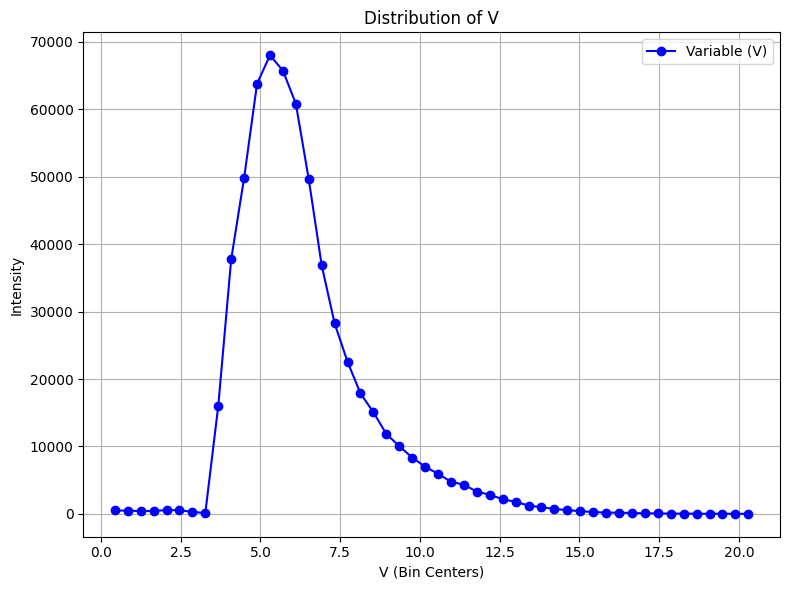

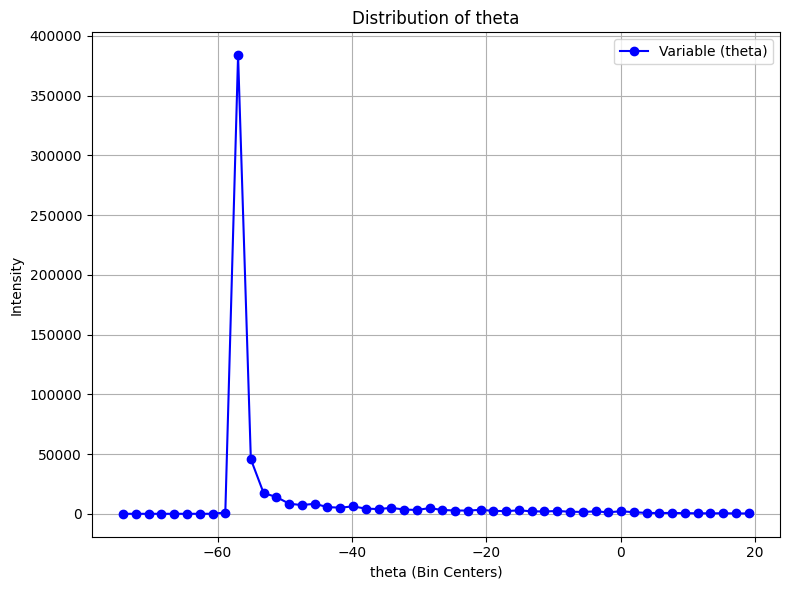

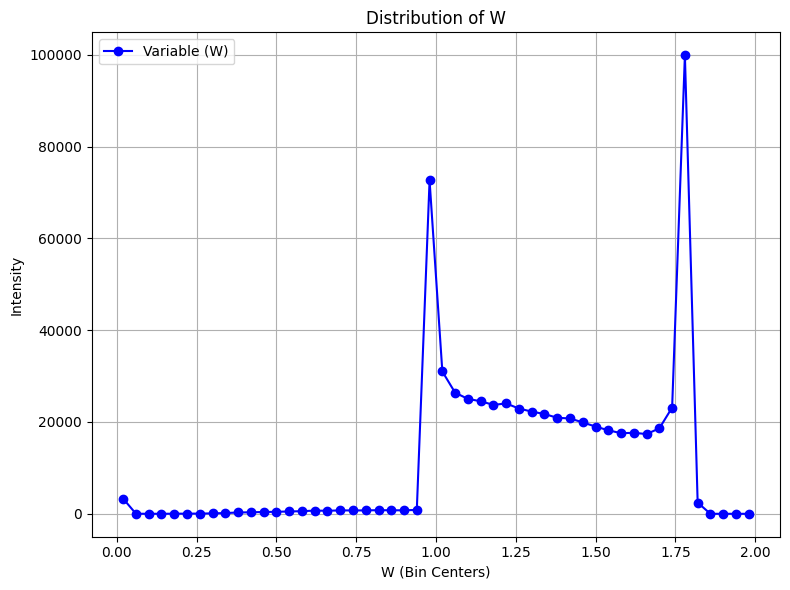

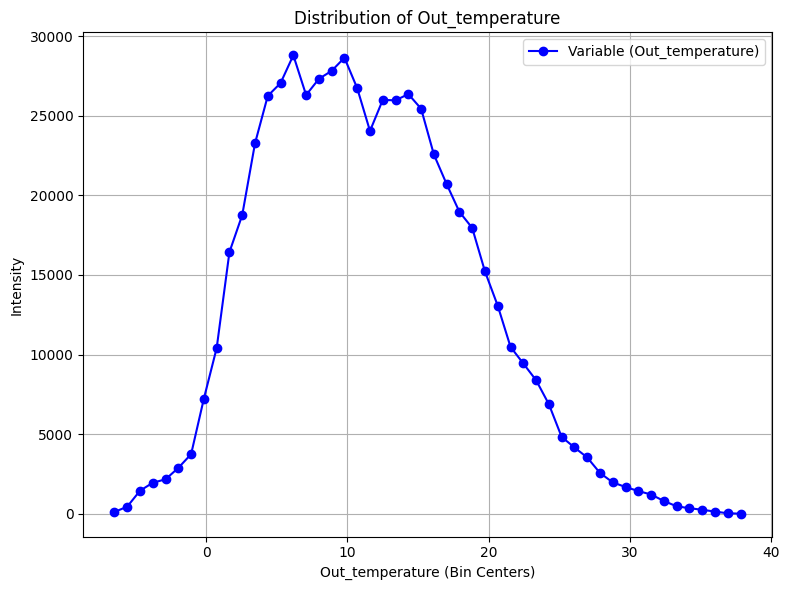

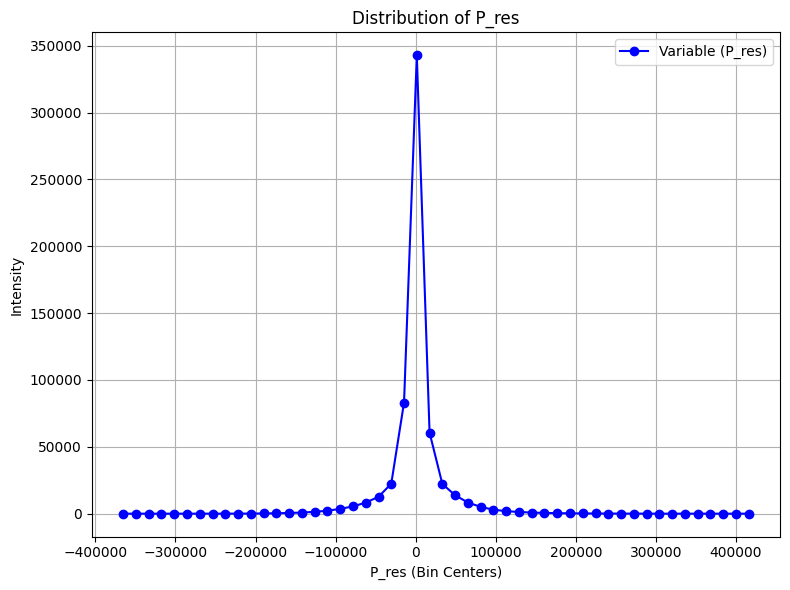

In [50]:
plot_distro('V')
plot_distro('theta',lims=[-75,20])
plot_distro('W',lims=[0,2])
plot_distro('Out_temperature')
plot_distro('P_res')


In [114]:
# Define importance as the variable distribution, weighted by its abs residual power

def plot_importance(Var_name,nbins=50,lims=None,threshold=2):
    
    # Extract res_data (Pres) and scale it to kW units
    res_data = dataset['P_res'].to_numpy() / 1000

    X_data = dataset[Var_name].to_numpy()  # Set X_data based on the variable
    if lims is None:
        xmin,xmax = X_data.min(), X_data.max()
    else:
        xmin = lims[0]
        xmax = lims[1]

    # Step 1: Compute the histogram of X_data with 50 bins        
    histo_x, bin_edges = np.histogram(X_data, bins=nbins,range=(xmin,xmax))

    # Step 2: Compute the mean of res_data (Pres) for each bin in X_data
    res_mean = np.zeros(nbins)

    # Digitize X_data to find which bin each value belongs to
    bin_indices = np.digitize(X_data, bin_edges)

    # Compute the mean of Pres in each bin
    for i in range(1, nbins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:  # Avoid division by zero if no points are in a bin
            res_mean[i-1] = np.mean(abs(res_data[mask]))
        else:
            res_mean[i-1] = 0  # Handle empty bins

    # Step 3: Compute Importance_X as histo_x * Y_mean
    Importance_X = histo_x * res_mean

    # Step 4: Compute bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Remove less important regions
    x_vals = bin_centers
    pdf_vals = Importance_X
    pdf_vals /= np.trapz(pdf_vals, x_vals)  # Normalize PDF to ensure it integrates to 1
    mean = np.trapz(x_vals * pdf_vals, x_vals)  # ∑(x_i * f(x_i)) * Δx
    variance = np.trapz((x_vals - mean)**2 * pdf_vals, x_vals)  # ∑((x_i - mu)^2 * f(x_i)) * Δx
    sigma = np.sqrt(variance)  # Standard deviation is the square root of the variance
    print('mean,sigma:',mean,sigma)
    print('var_min,var_max:',mean-threshold*sigma,mean+threshold*sigma)
    Importance_filtered = Importance_X[(abs(x_vals-mean) <= threshold*sigma)]
    bins_filtered = bin_centers[(abs(x_vals-mean) <= threshold*sigma)]

    # Step 5: Plot Importance_X
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, Importance_X, marker='o', linestyle='-', color='b', label=f'Importance_X ({Var_name})')
    plt.plot(bins_filtered, Importance_filtered, marker='o', linestyle='-', color='orange', label=f'Filtered')

    # Add labels and titles
    plt.xlabel(f'{Var_name} (Bin Centers)')
    plt.ylabel('Importance_X')
    plt.title(f'Importance_X vs {Var_name}')
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

mean,sigma: 8.17306092041737 2.092573109103921
var_min,var_max: 3.9879147022095287 12.358207138625211


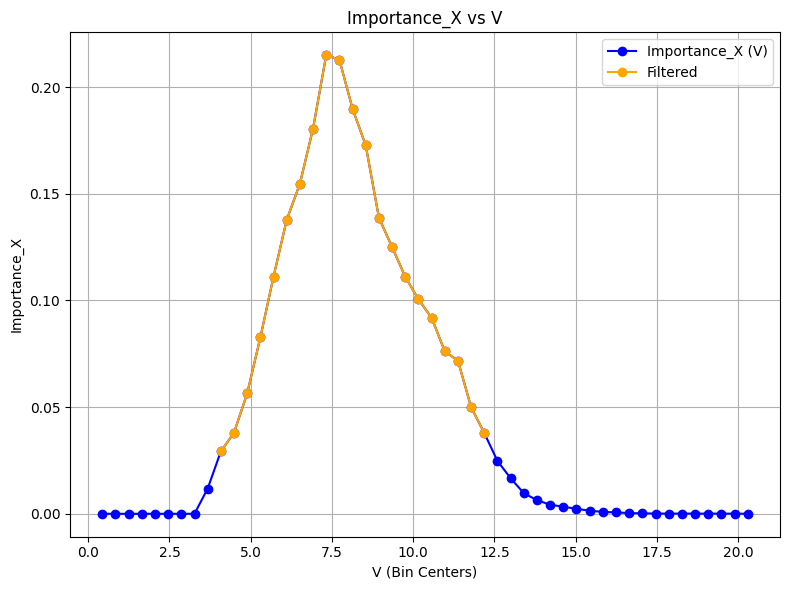

mean,sigma: -50.4379270536886 14.566264280872048
var_min,var_max: -79.57045561543269 -21.3053984919445


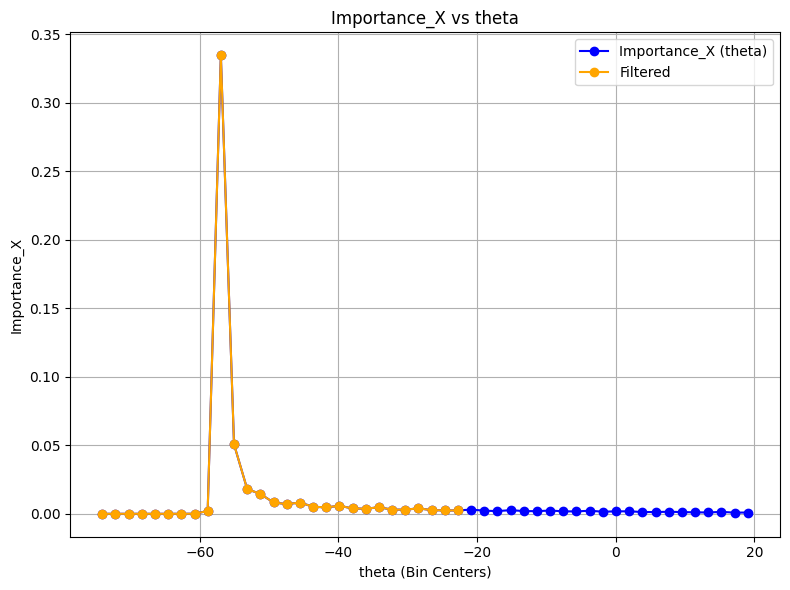

mean,sigma: 1.632237410838913 0.22937503997811082
var_min,var_max: 1.1734873308826914 2.0909874907951345


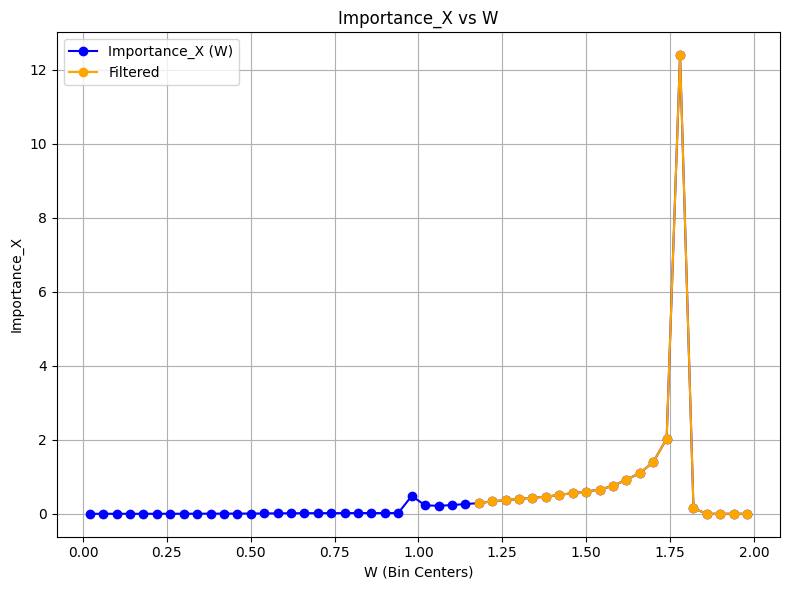

mean,sigma: 10.698162773970711 7.2761347049887855
var_min,var_max: -3.8541066360068594 25.250432183948284


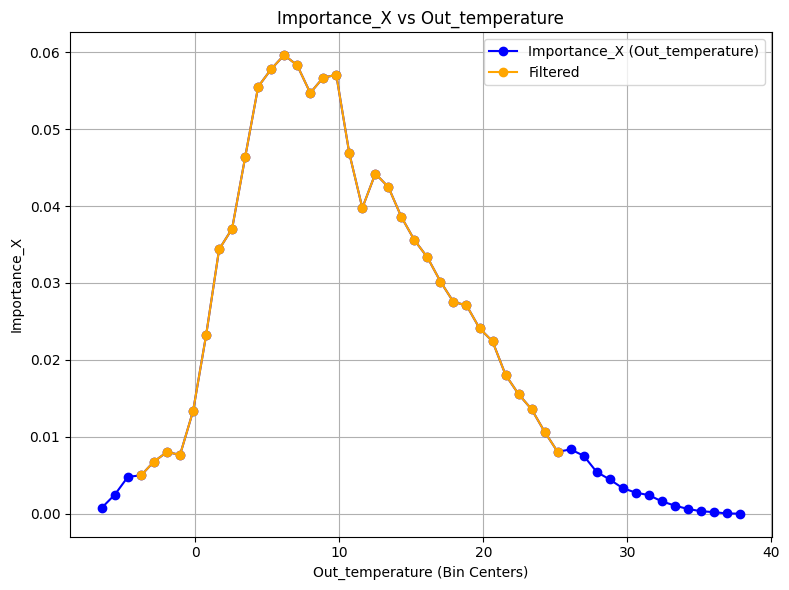

mean,sigma: 3577.0464721185444 74999.63330462606
var_min,var_max: -146422.22013713355 153576.31308137067


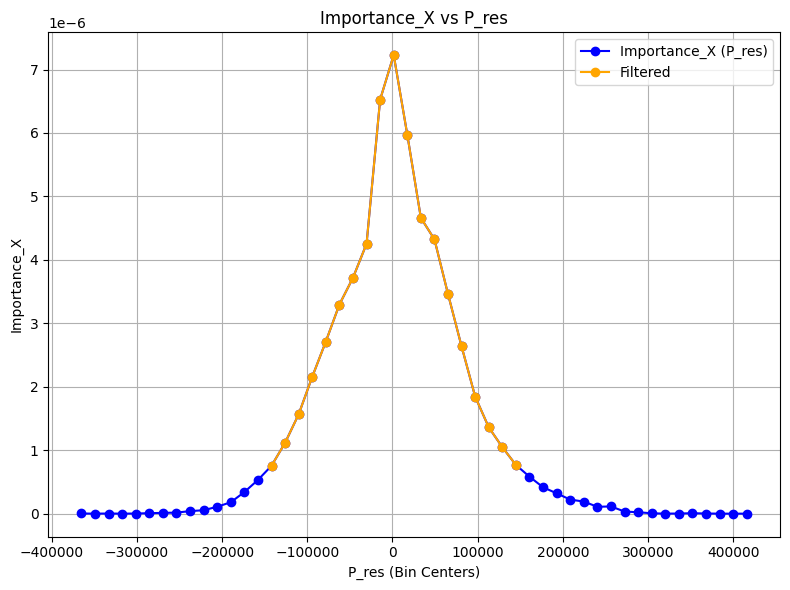

In [116]:
plot_importance('V',threshold=2)
plot_importance('theta',lims=[-75,20],threshold=2)
plot_importance('W',lims=[0,2],threshold=2)
plot_importance('Out_temperature',threshold=2)
plot_importance('P_res',threshold=2)

In [100]:
# Compare distribution with importance

def plot_distro_importance(Var_name,nbins=50,lims=None):
    
    # Extract res_data (Pres) and scale it to kW units
    res_data = dataset['P_res'].to_numpy() / 1000

    X_data = dataset[Var_name].to_numpy()  # Set X_data based on the variable
    if lims is None:
        xmin,xmax = X_data.min(), X_data.max()
    else:
        xmin = lims[0]
        xmax = lims[1]

    # Step 1: Compute the histogram of X_data with 50 bins        
    histo_x, bin_edges = np.histogram(X_data, bins=nbins,range=(xmin,xmax))

    # Step 2: Compute the mean of res_data (Pres) for each bin in X_data
    res_mean = np.zeros(nbins)

    # Digitize X_data to find which bin each value belongs to
    bin_indices = np.digitize(X_data, bin_edges)

    # Compute the mean of Pres in each bin
    for i in range(1, nbins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:  # Avoid division by zero if no points are in a bin
            res_mean[i-1] = np.mean(abs(res_data[mask]))
        else:
            res_mean[i-1] = 0  # Handle empty bins

    # Step 3: Compute Importance_X as histo_x * Y_mean
    Importance_X = histo_x * res_mean

    # Step 4: Compute bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Normalize
    histo_x = histo_x.astype(float)  # Convert histo_x to float64
    histo_x /= np.trapz(histo_x, bin_centers)
    Importance_X /= np.trapz(Importance_X, bin_centers)

    # Step 5: Plot Importance_X
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, histo_x, marker='o', linestyle='-', color='b', label=f'Distribution')
    plt.plot(bin_centers, Importance_X, marker='o', linestyle='-', color='r', label=f'Importance ({Var_name})')

    # Add labels and titles
    plt.xlabel(f'{Var_name} (Bin Centers)')
    plt.ylabel('Intensity')
    plt.title(f'Distribution and Importance_X {Var_name}')
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

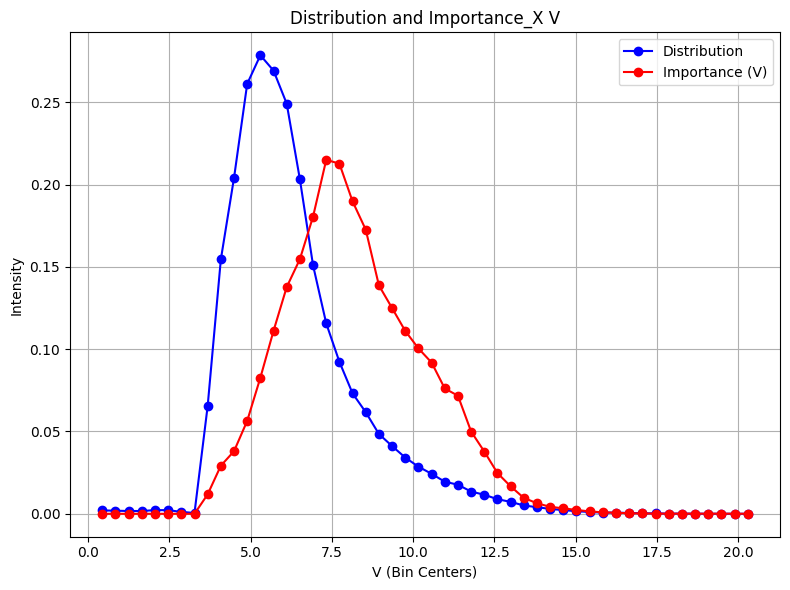

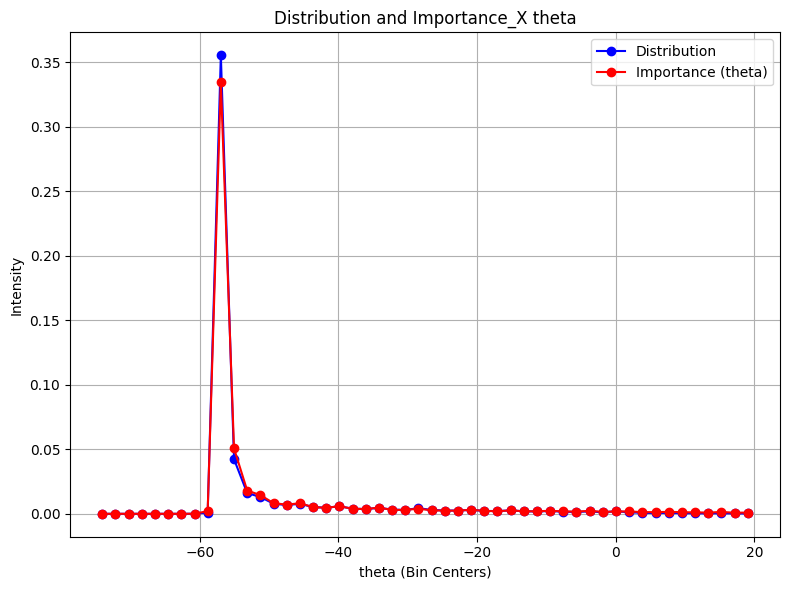

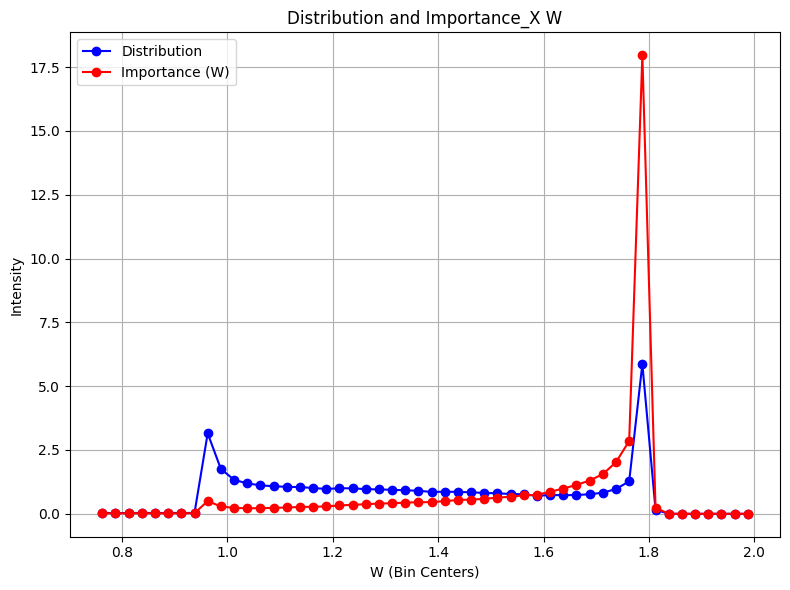

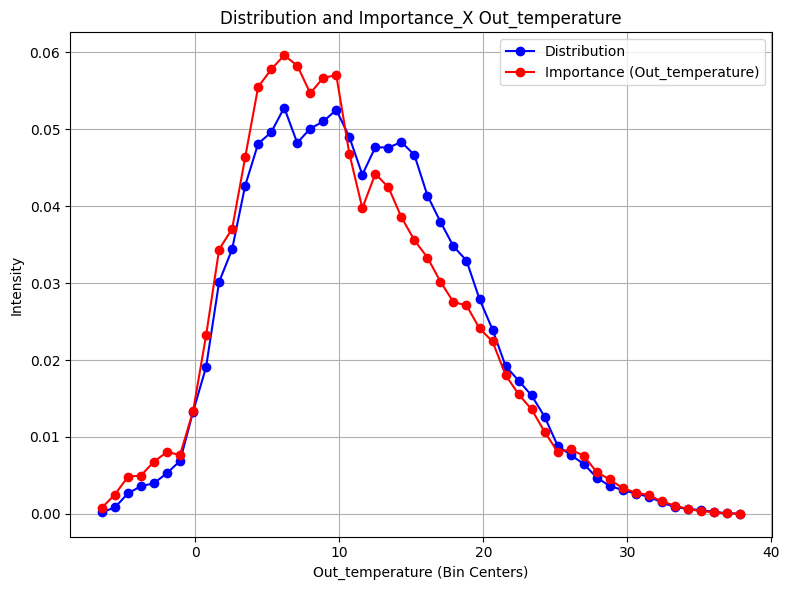

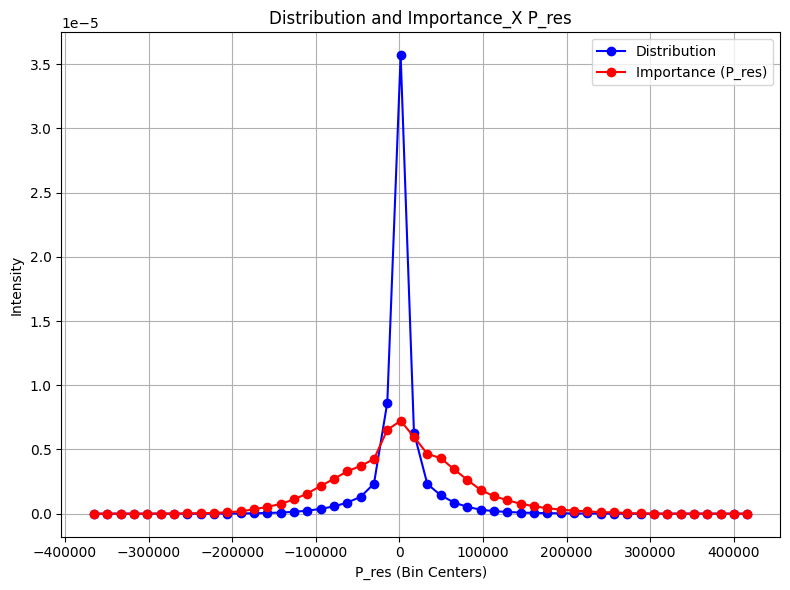

In [102]:
plot_distro_importance('V')
plot_distro_importance('theta',lims=[-75,20])
plot_distro_importance('W',lims=[0.75,2])
plot_distro_importance('Out_temperature')
plot_distro_importance('P_res')

mean,sigma: 8.17306092041737 2.092573109103921
var_min,var_max: 6.08048781131345 10.26563402952129


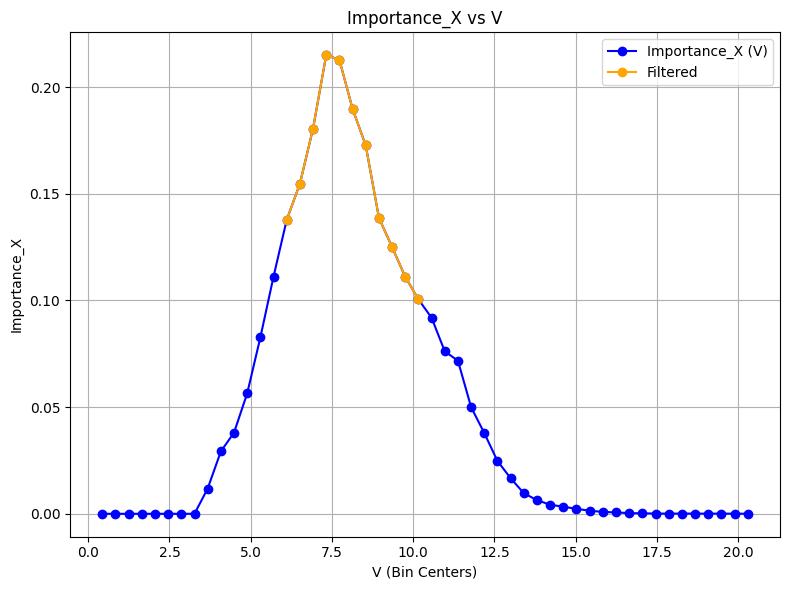

mean,sigma: -50.4379270536886 14.566264280872048
var_min,var_max: -65.00419133456064 -35.87166277281655


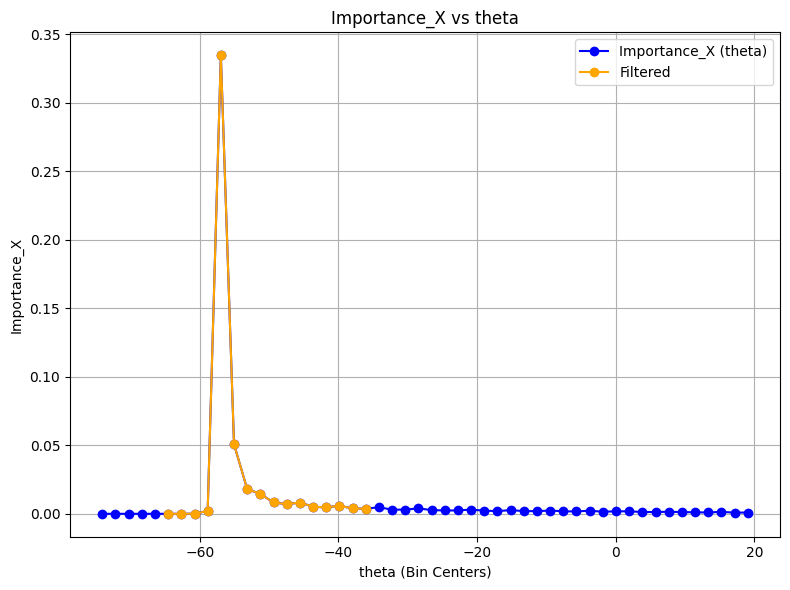

mean,sigma: 1.632237410838913 0.22937503997811082
var_min,var_max: 1.4028623708608023 1.8616124508170238


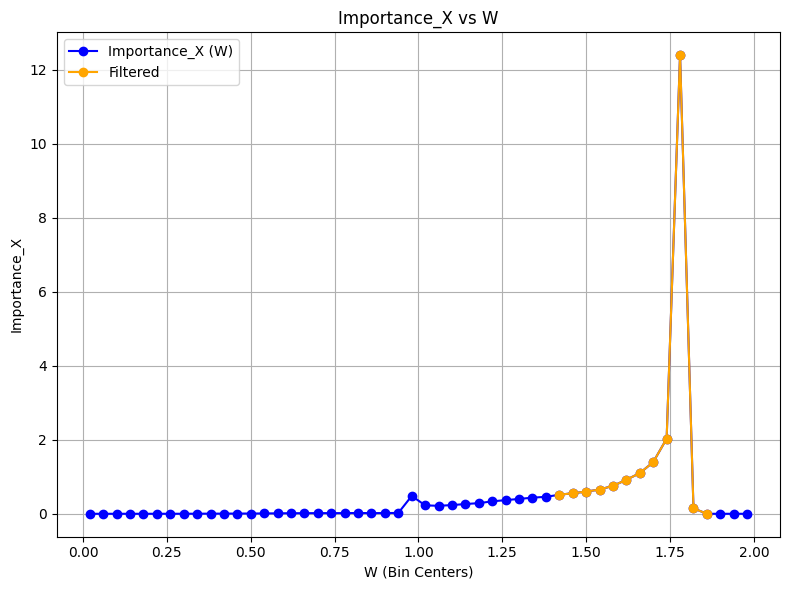

mean,sigma: 10.698162773970711 7.2761347049887855
var_min,var_max: 3.422028068981926 17.974297478959496


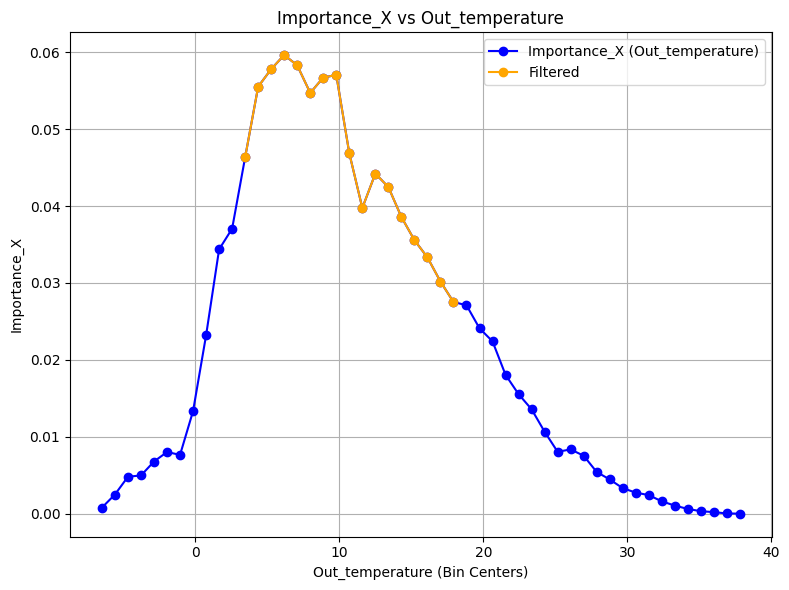

mean,sigma: 3577.0464721185444 74999.63330462606
var_min,var_max: -71422.58683250751 78576.6797767446


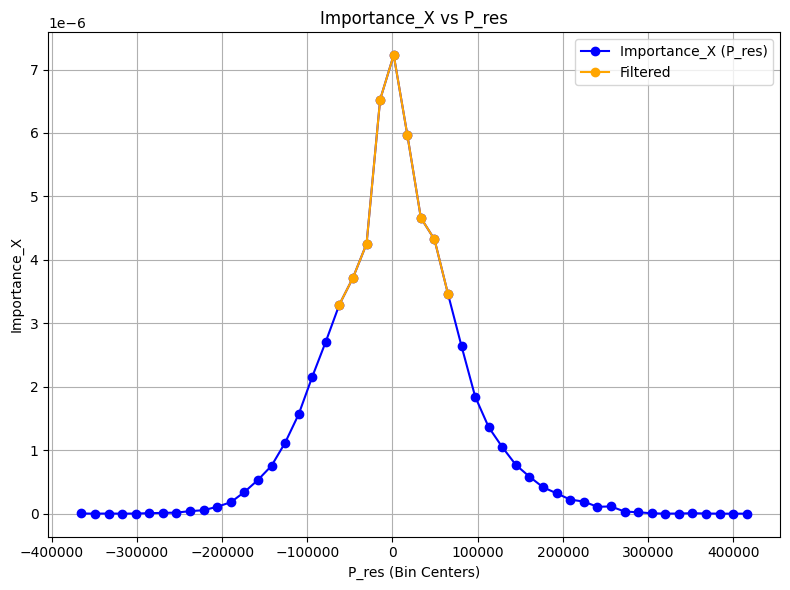

In [124]:
plot_importance('V',threshold=1)
plot_importance('theta',lims=[-75,20],threshold=1)
plot_importance('W',lims=[0,2],threshold=1)
plot_importance('Out_temperature',threshold=1)
plot_importance('P_res',threshold=1)

In [125]:
# Trying to improve the prediction into the region with highest residual

# Define regions limits for 2 sigmas
#Vmin, Vmax = 3.99, 12.36
#thetamin, thetamax = -79.57, -21.31
#Wmin, Wmax = 1.17, 2.09
#Tmin, Tmax = -3.85, 25.25

# Define regions limits for 1 sigma
Vmin, Vmax = 6.08, 10.27
thetamin, thetamax = -65.00, -35.87
Wmin, Wmax = 1.4, 1.86
Tmin, Tmax = 3.42, 17.97

dataset_red = dataset.sample(frac=0.8, random_state=10) # training dataset
# Apply the filtering conditions to the DataFrame
dataset_red = dataset_red[
    (dataset_red['V'] >= Vmin) & (dataset_red['V'] <= Vmax) &
    (dataset_red['theta'] >= thetamin) & (dataset_red['theta'] <= thetamax) &
    (dataset_red['W'] >= Wmin) & (dataset_red['W'] <= Wmax) &
    (dataset_red['Out_temperature'] >= Tmin) & (dataset_red['Out_temperature'] <= Tmax)
]

# Normalize dataset
x_mean = np.nanmean( dataset_red, axis=0)
x_std = np.nanstd( dataset_red, axis=0 )
column_name = dataset_red.columns.values
Cp_column = column_name[5]
Cp_max = 0.5926
dataset_red_norm = dataset_red.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        dataset_red_norm[col]=(dataset_red[col]-x_mean[icol])/x_std[icol]        
    else: # Cp in [0,1]
        dataset_red_norm[col]=dataset_red[col]/Cp_max
    icol = icol+1

# Print or use the filtered dataframe
print(dataset_red.shape)

(132085, 20)


  Feature  Coefficient  Abs_Coefficient
2       T    -0.259579         0.259579
0       W    -0.118151         0.118151
1       V     0.109085         0.109085
3   theta    -0.052478         0.052478
Model coefficients: [-0.118  0.109 -0.26  -0.052]
Intercept: 1.8402553170751442e-16
R-squared: 0.06898988982265886


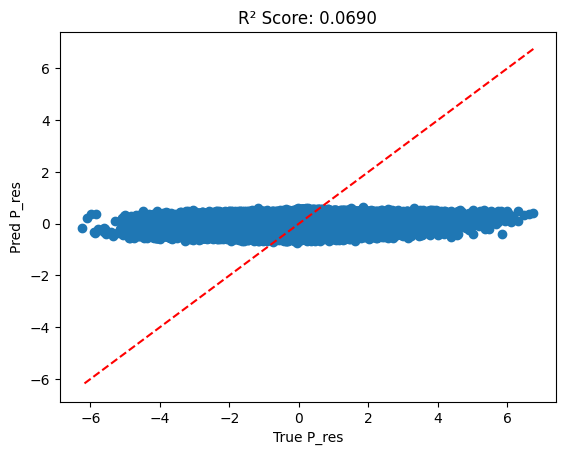

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

V = dataset_red_norm['V'].to_numpy()
W = dataset_red_norm['W'].to_numpy()
T = dataset_red_norm['Out_temperature'].to_numpy()
theta = dataset_red_norm['theta'].to_numpy()
Y = dataset_red_norm['P_res'].to_numpy()

# Create the feature matrix based on the assumed model: W, V, T
X = np.column_stack((W, V, T,theta))

# Generate all polynomial features up to second order (including interaction terms)
poly = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly.fit_transform(X)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_poly, Y)

# Get the predicted values
Y_pred = model.predict(X_poly)

# Calculate R-squared score
r2 = r2_score(Y, Y_pred)

# Get model coefficients
coefficients = model.coef_
# Get feature names for each term
feature_names = poly.get_feature_names_out(['W', 'V', 'T','theta'])
# Create a dataframe for feature names and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# Sort by the absolute value of the coefficients to find the most important terms
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
# Print the sorted coefficients
print(coef_df)


# Print model coefficients and R-squared score
print("Model coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R-squared:", r2)

# Optional: Plot the predictions vs actual
p1 = max(max(Y_pred), max(Y))
p2 = min(min(Y_pred), min(Y))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(Y, Y_pred)
plt.xlabel('True P_res')
plt.ylabel('Pred P_res')
plt.title(f'R² Score: {r2:.4f}')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Fitted C_T: -1226.0727, Fitted T0: 3.9943, Fitted C_V: 375.5337, Fitted V0: 9.5055, Fitted C_W: -5959.7743, Fitted W0: 3.2012
R² score: 0.0803


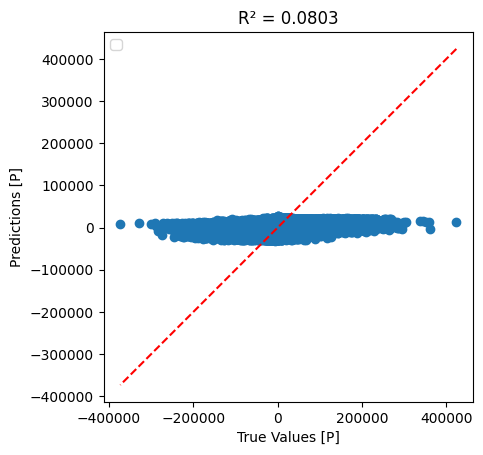

In [131]:
# Fit P_res as C_T*(T-T0) in original units

from scipy.optimize import curve_fit

# Define the regression function: C_T * (T - T0)
def model_func(XX, C_T, T0, C_V, V0, C_W, W0):
    T, V, W = XX
    return C_T * (T - T0) + C_V*(V-V0) + C_W*(W-W0)

# Assuming T is the feature and Y is the target
XX_data = dataset[['Out_temperature','V','W']].to_numpy().T
YY = dataset['P_res'].to_numpy()

# Fit the model to the data
#initial_guess = [-1_000, 15.0]  # Initial guess for C_T and T0
initial_guess = [-1_000, 15.0, -2_000, 10.0, 1_000, 1.6]  
params, covariance = curve_fit(model_func, XX_data, YY, p0=initial_guess)

# Extract fitted parameters
C_T, T0, C_V, V0, C_W, W0 = params
print(f"Fitted C_T: {C_T:.4f}, Fitted T0: {T0:.4f}, Fitted C_V: {C_V:.4f}, Fitted V0: {V0:.4f}, Fitted C_W: {C_W:.4f}, Fitted W0: {W0:.4f}")

# Predict Y using the fitted model
Y_pred = model_func(XX_data, *params)

# Calculate R² score
r2 = 1 - (np.sum((YY - Y_pred)**2) / np.sum((YY - np.mean(YY))**2))
#r2 = r2_score(Y, Y_pred)
print(f"R² score: {r2:.4f}")

# Plot the actual vs predicted values
a = plt.axes(aspect='equal')
p1 = max(max(Y_pred), max(YY))
p2 = min(min(Y_pred), min(YY))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(YY, Y_pred)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
#_ = plt.plot(lims, lims)
plt.title(f'R² = {r2:.4f}')
plt.legend()
plt.show()


### Causal Analysis

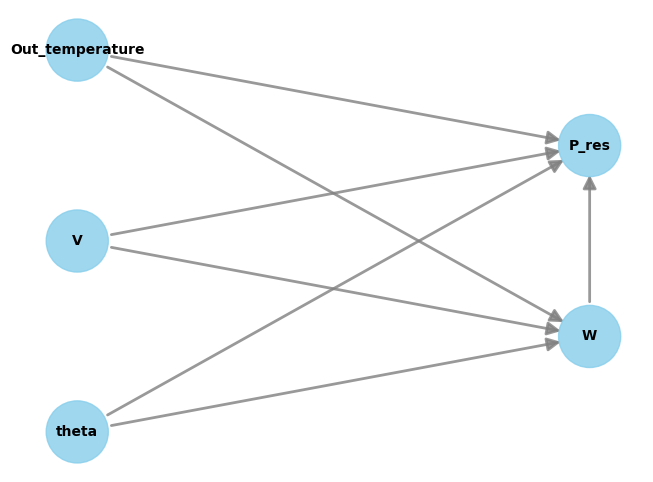

In [139]:
# Step 1: Define the Causal Model
import dowhy
from dowhy import CausalModel

# Assuming you have a pandas DataFrame dataset_red containing the variables
data = dataset_red[['V', 'theta', 'W', 'Out_temperature', 'P_res']]

# Step 1: Define the Causal Model using a causal graph in DOT format
# W is the treatment, and P_res is the outcome.
causal_graph = """
digraph {
    W -> P_res;
    V -> P_res;
    theta -> P_res;
    Out_temperature -> P_res;
    V -> W;
    theta -> W;
    Out_temperature -> W;
}
"""

# Create the causal model with W as the treatment (intervention) variable
model = CausalModel(
    data=data,
    treatment="W",   # Specify W as the intervention (treatment)
    outcome="P_res", # Outcome is P_res
    graph=causal_graph
)

# Visualize the causal graph
model.view_model()

In [140]:
# Step 2: Identify the Causal Effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                    
────(E[P_res|theta,V,Out_temperature])
d[W]                                  
Estimand assumption 1, Unconfoundedness: If U→{W} and U→P_res then P(P_res|W,theta,V,Out_temperature,U) = P(P_res|W,theta,V,Out_temperature)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [141]:
# Step 3: Estimate the Causal Effect

# Estimate the effect of W on P_res using linear regression
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                    
────(E[P_res|theta,V,Out_temperature])
d[W]                                  
Estimand assumption 1, Unconfoundedness: If U→{W} and U→P_res then P(P_res|W,theta,V,Out_temperature,U) = P(P_res|W,theta,V,Out_temperature)

## Realized estimand
b: P_res~W+theta+V+Out_temperature
Target units: ate

## Estimate
Mean value: -36217.335297152975



/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [142]:
# Step 4: Refute the Estimate

# Refute the causal estimate to check robustness
refutation = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter")
print(refutation)

/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estim

Refute: Use a Placebo Treatment
Estimated effect:-36217.335297152975
New effect:3.7198333302512765e-10
p value:0.0



/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estim

In [143]:
from econml.dml import LinearDML

# Assuming dataset_red is your DataFrame
X = dataset_red[['V', 'theta', 'Out_temperature']]  # Features (controls)
T = dataset_red['W']  # Treatment (intervention)
Y = dataset_red['P_res']  # Outcome (target)

In [144]:
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

# Define the model
# Using RandomForest as the machine learning model for controls, Lasso for final stage treatment effect estimation
model = LinearDML(
    model_y=Lasso(),
    model_t=Lasso(),
    featurizer=None,  # No additional feature transformation, using raw X
    random_state=42
)

# Fit the model to the data
model.fit(Y, T, X=X)

In [145]:
ate = model.ate(X=X)
print(f"Average Treatment Effect (ATE) of W on P_res: {ate:.4f}")

Average Treatment Effect (ATE) of W on P_res: -7663.1326


In [146]:
treatment_effects = model.effect(X)
print(f"Individual Treatment Effects (ITE): {treatment_effects}")

Individual Treatment Effects (ITE): [-20469.765  25422.296 -16304.759 ... -32899.312  44211.118  16517.041]


In [147]:
lower, upper = model.ate_interval(X=X)
print(f"ATE 95% confidence interval: [{lower:.4f}, {upper:.4f}]")

ATE 95% confidence interval: [-9511.5769, -5814.6884]


In [148]:
from econml.dml import LinearDML
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

# Assuming dataset_red is your DataFrame
X = dataset_red[['V', 'theta', 'Out_temperature']]  # Features (controls)
T = dataset_red['W']  # Treatment (intervention)
Y = dataset_red['P_res']  # Outcome (target)

# Define the model
model = LinearDML(
    model_y=Lasso(),       # Model for the outcome regression
    model_t=Lasso(),       # Model for the treatment regression
    featurizer=None,       # No feature transformation, just raw X
    random_state=42
)

# Fit the model
model.fit(Y, T, X=X)

# Estimate the Average Treatment Effect (ATE)
ate = model.ate(X=X)
print(f"Average Treatment Effect (ATE) of W on P_res: {ate:.4f}")

# Estimate Individual Treatment Effects (ITE)
treatment_effects = model.effect(X)
print(f"Individual Treatment Effects (ITE): {treatment_effects}")

# Confidence intervals for the ATE
lower, upper = model.ate_interval(X=X)
print(f"ATE 95% confidence interval: [{lower:.4f}, {upper:.4f}]")


Average Treatment Effect (ATE) of W on P_res: -7663.1326
Individual Treatment Effects (ITE): [-20469.765  25422.296 -16304.759 ... -32899.312  44211.118  16517.041]
ATE 95% confidence interval: [-9511.5769, -5814.6884]
